<font size="3">Project Documentation for Heart Disease Prediction

Introduction

This project aims to develop a predictive model for heart disease using a comprehensive dataset containing various clinical features. The dataset includes key attributes such as age, sex, chest pain type (cp), resting blood pressure (trestbps), cholesterol levels (chol), fasting blood sugar (fbs), resting electrocardiographic results (restecg), maximum heart rate achieved (thalach), exercise angina (exang), depression induced by exercise (oldpeak), slope of the peak exercise ST segment (slope), number of major vessels colored by fluoroscopy (ca), thalassemia (thal), and the target variable indicating the presence of heart disease.

Dataset Features

Age: Age of the patient (in years).

Sex: Gender of the patient (1 = male; 0 = female).

cp (chest pain type): Type of chest pain experienced by the patient (ranging from 0 to 3).

trestbps: Resting blood pressure (in mm Hg).

chol: Serum cholesterol level (in mg/dl).

fbs: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false).

restecg: Results of the resting electrocardiographic test (0, 1, 2).

thalach: Maximum heart rate achieved (in beats per minute).

exang: Exercise induced angina (1 = yes; 0 = no).

oldpeak: ST depression induced by exercise relative to rest.

slope: Slope of the peak exercise ST segment (0, 1, 2).

ca: Number of major vessels colored by fluoroscopy (0-3).

thal: Thalassemia status (1 = normal; 2 = fixed defect; 3 = reversible defect).

target: Presence of heart disease (1 = disease present; 0 = no disease).</font>

<font size="3">Importing Required Libraries

In this section, we import the necessary libraries for data handling, visualization, preprocessing, and building the deep learning model.</font>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import classification_report , confusion_matrix  , roc_curve, auc 
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor
from imblearn.combine import SMOTETomek
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

<font size="3">Loading and Exploring the Dataset

We load the dataset and check its structure, including image dimensions and labels. This helps us understand what kind of data we are working with.</font>

In [2]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<font size="3">Exploratory Data Analysis (EDA)

In this section, we check the basic structure of the dataset and look for missing values or abnormal data.</font>

In [3]:
np.unique(data.target , return_counts=True)

(array([0, 1], dtype=int64), array([138, 165], dtype=int64))

In [4]:
data.isnull().sum()


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
data.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


In [7]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


<font size="3">Distribution plot of cholesterol levels in patients, illustrating the frequency and variability of cholesterol levels as a risk factor for heart disease.</font>

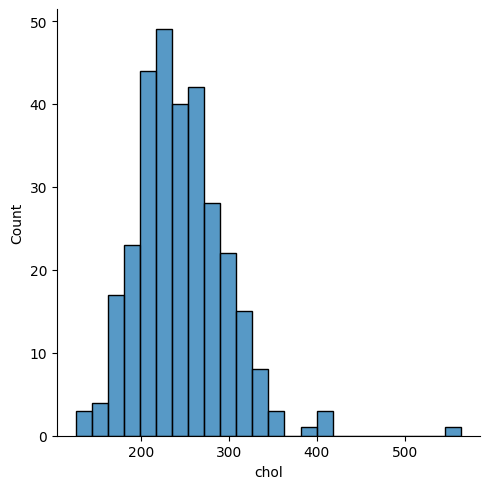

In [8]:
sns.displot(data['chol'])

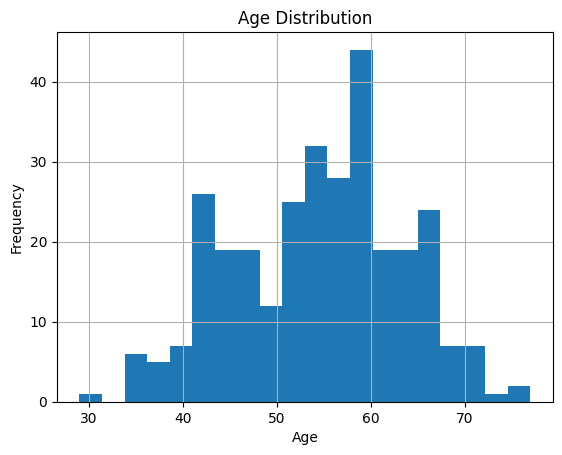

In [9]:
data['age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

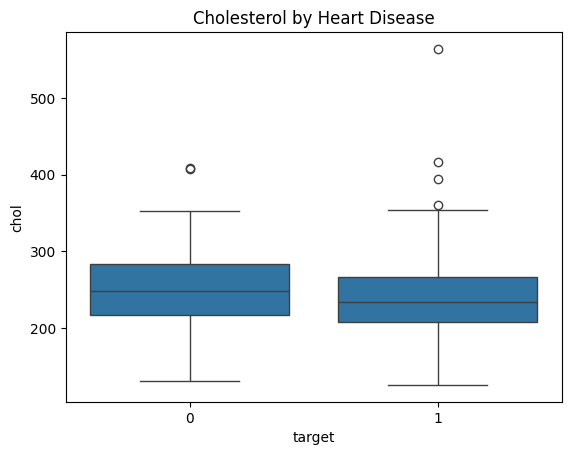

In [10]:
sns.boxplot(x='target', y='chol', data=data)
plt.title('Cholesterol by Heart Disease')
plt.show()

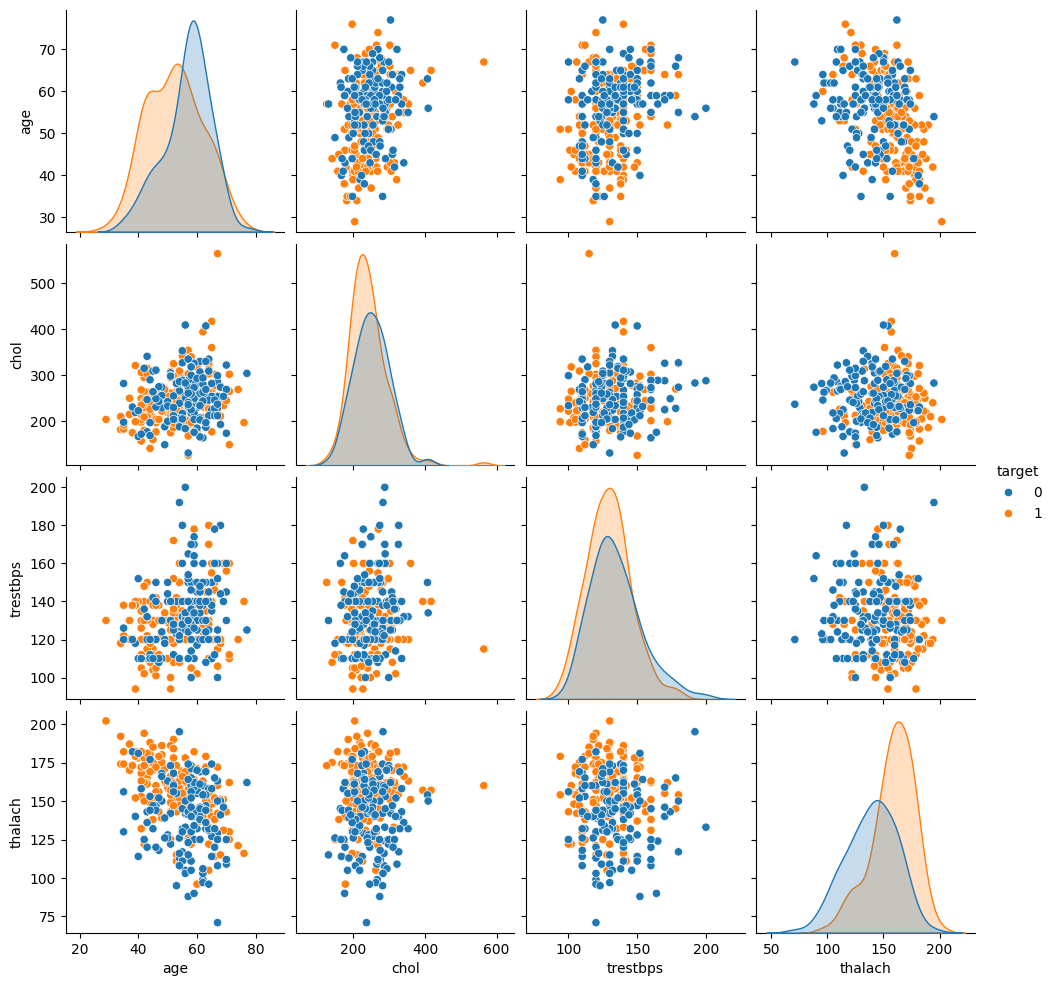

In [11]:
sns.pairplot(data[['age', 'chol', 'trestbps', 'thalach', 'target']], hue='target')
plt.show()

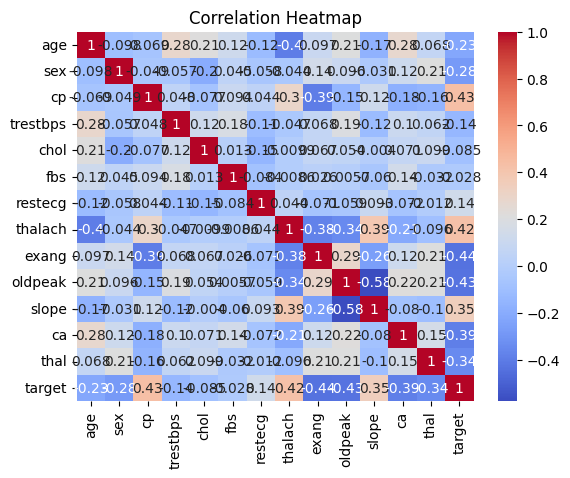

In [12]:
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

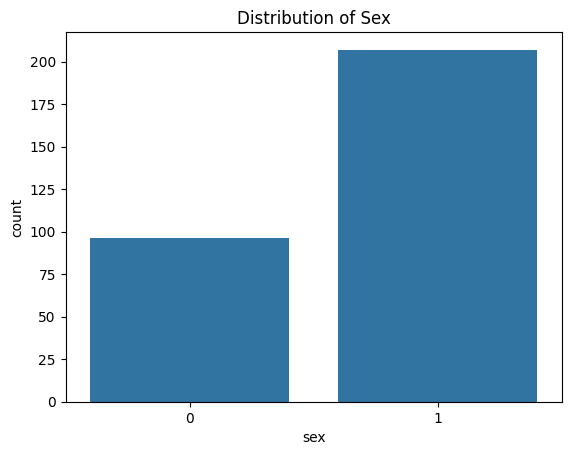

In [13]:
sns.countplot(x='sex', data=data)
plt.title('Distribution of Sex')
plt.show()

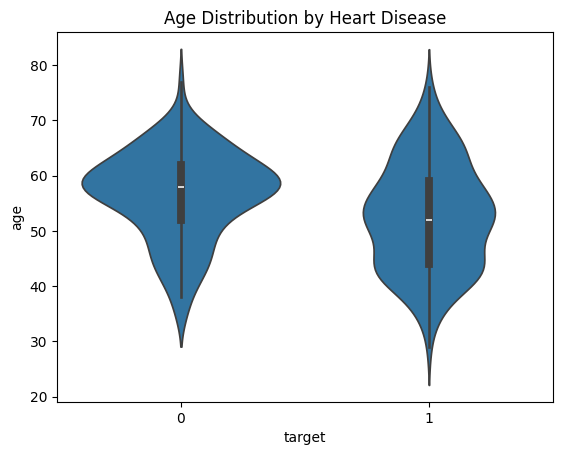

In [14]:
sns.violinplot(x='target', y='age', data=data)
plt.title('Age Distribution by Heart Disease')
plt.show()

<font size="3">Distribution plot of fbs</font>

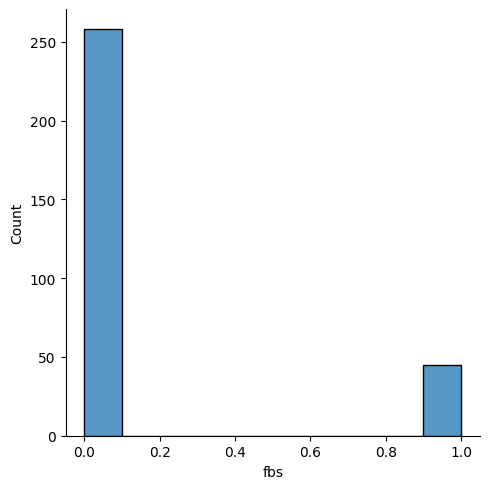

In [15]:
sns.displot(data['fbs'])

In [16]:
data.drop(columns=['fbs'] , inplace=True)

<font size="3">Scaling Data and Splitting Data into Training and Testing Sets

We split the dataset into training and testing sets using a fixed random seed for reproducibility.</font>

In [17]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
x_train , x_test , y_train , y_test = train_test_split(X , y ,test_size=0.25 , random_state=42)

<font size="3">Drop Outlier data</font>

In [18]:
lof = LocalOutlierFactor(n_neighbors=3)
y_pred = lof.fit_predict(X)
y_pred[y_pred == -1] = 1
y_pred[y_pred == 1] = 0

In [19]:
data[y_pred == 0]

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,1,115,1,1.2,1,1,3,0


<font size="3">Balance data with Smotetomek</font>

In [20]:
st = SMOTETomek(random_state=42)
X_smote, y_smote = st.fit_resample(x_train, y_train)
print(len(X_smote) , len(y_smote))

220 220


<font size="3">train test split data</font>

In [21]:
x_train , x_test , y_train , y_test = train_test_split(X_smote , y_smote ,test_size=0.25 , random_state=42)

<font size="3">Gridsearch to find the best hyperparameters for the SVM model</font>

In [22]:
parameter = {'C':np.arange(0.1, 10, 0.1) , 'kernel':['linear' , 'rbf' , 'poly']}
grid_search = GridSearchCV(SVC() , cv=5, param_grid=parameter , scoring='accuracy')
grid_search.fit(x_train , y_train)
print(f'best parames = {grid_search.best_params_}')

best parames = {'C': 1.3000000000000003, 'kernel': 'rbf'}


<font size="3">1)Heart Disease Prediction with SVM algorithm</font>

In [23]:
svc_model = SVC(kernel='poly' , C=2.9)
svc_model.fit(x_train, y_train)
y_pred = svc_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        28
           1       0.87      1.00      0.93        27

    accuracy                           0.93        55
   macro avg       0.94      0.93      0.93        55
weighted avg       0.94      0.93      0.93        55



<font size="3">confusion matrix</font>

In [24]:
print(confusion_matrix(y_test,y_pred))


[[24  4]
 [ 0 27]]


<font size='3'>Displaying the Confusion Matrix 

In this section, we create and visualize the confusion matrix to assess the performance of our classification model.
The confusion matrix summarizes the true positive, true negative, false positive, and false negative predictions. 
This helps us understand how well the model is performing in distinguishing between fraudulent and non-fraudulent transactions</font>


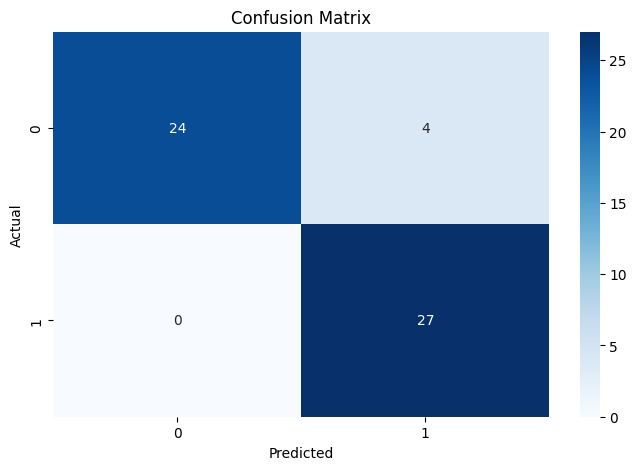

In [25]:
cm = confusion_matrix(y_test , y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm,annot=True, fmt='d' , cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<font size=3>ROC Curve

This ROC Curve visualizes the performance of the trained model at various threshold settings. The curve illustrates the trade-off between the True Positive Rate (Recall) and the False Positive Rate across different classification thresholds. A model with a perfect classification capability would have a curve that follows the left-hand border and then the top border of the ROC space, resulting in an area under the curve (AUC) of 1.0. The closer the curve is to the top left corner, the better the model's performance.</font>

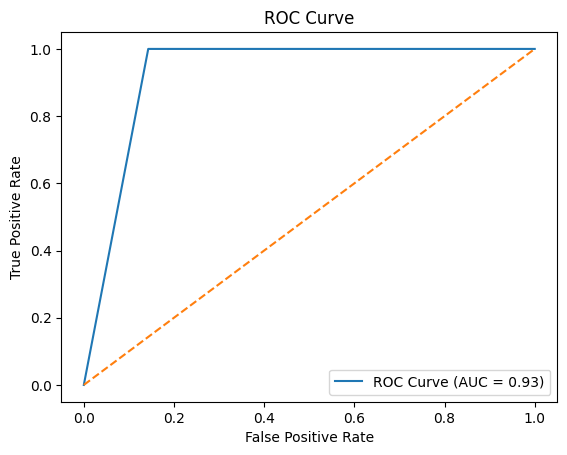

In [26]:
y_probs = svc_model.predict(x_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

<font size="3">2)catboost model</font>

In [27]:
catboost_model = CatBoostClassifier(iterations=300,
                              learning_rate=0.05,
                              depth=8,
                              eval_metric='Recall',
                              bagging_temperature = 0.2,
                              od_type='Iter',
                              metric_period = 75,
                              od_wait=100,
                              random_state=42)
catboost_model.fit(x_train, y_train, eval_set=(x_test , y_test), early_stopping_rounds=200)

0:	learn: 0.8554217	test: 0.8148148	best: 0.8148148 (0)	total: 141ms	remaining: 42.1s
75:	learn: 1.0000000	test: 0.9629630	best: 0.9629630 (4)	total: 257ms	remaining: 759ms
150:	learn: 1.0000000	test: 0.9629630	best: 1.0000000 (107)	total: 396ms	remaining: 390ms
225:	learn: 1.0000000	test: 0.9629630	best: 1.0000000 (107)	total: 517ms	remaining: 169ms
299:	learn: 1.0000000	test: 0.9629630	best: 1.0000000 (107)	total: 645ms	remaining: 0us

bestTest = 1
bestIteration = 107

Shrink model to first 108 iterations.


<font size="3">catboost model accuracy on train data</font>

In [28]:
y_pred = catboost_model.predict(x_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        83

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165



<font size="3">catboost model accuracy on test data</font>

In [29]:
y_pred = catboost_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.93      1.00      0.96        27

    accuracy                           0.96        55
   macro avg       0.97      0.96      0.96        55
weighted avg       0.97      0.96      0.96        55



<font size="3">confusion matrix</font>

In [30]:
print(confusion_matrix(y_test,y_pred))

[[26  2]
 [ 0 27]]


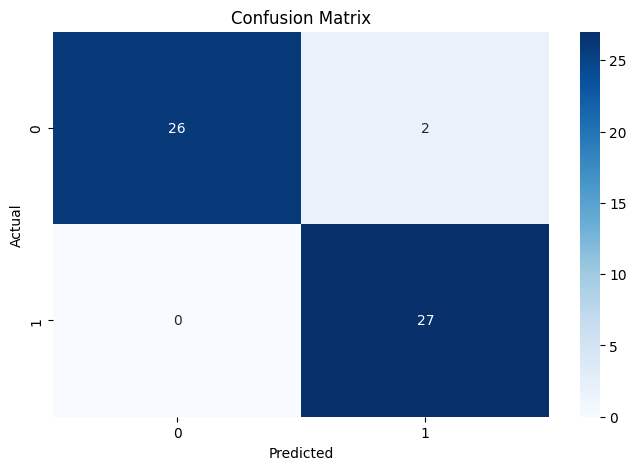

In [31]:
cm = confusion_matrix(y_test , y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm,annot=True, fmt='d' , cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<font size="3">cross validation</font>

In [32]:
cv_scores  = cross_val_score(catboost_model , x_train , y_train , cv=5 , scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

0:	learn: 0.9090909	total: 3.79ms	remaining: 1.13s
75:	learn: 1.0000000	total: 113ms	remaining: 333ms
150:	learn: 1.0000000	total: 224ms	remaining: 221ms
225:	learn: 1.0000000	total: 333ms	remaining: 109ms
299:	learn: 1.0000000	total: 438ms	remaining: 0us
0:	learn: 0.9242424	total: 1.78ms	remaining: 532ms
75:	learn: 1.0000000	total: 107ms	remaining: 316ms
150:	learn: 1.0000000	total: 232ms	remaining: 229ms
225:	learn: 1.0000000	total: 357ms	remaining: 117ms
299:	learn: 1.0000000	total: 471ms	remaining: 0us
0:	learn: 0.9242424	total: 3.82ms	remaining: 1.14s
75:	learn: 1.0000000	total: 125ms	remaining: 369ms
150:	learn: 1.0000000	total: 241ms	remaining: 238ms
225:	learn: 1.0000000	total: 356ms	remaining: 117ms
299:	learn: 1.0000000	total: 472ms	remaining: 0us
0:	learn: 0.8507463	total: 1.93ms	remaining: 578ms
75:	learn: 1.0000000	total: 104ms	remaining: 307ms
150:	learn: 1.0000000	total: 217ms	remaining: 215ms
225:	learn: 1.0000000	total: 329ms	remaining: 108ms
299:	learn: 1.0000000	tota

<font size="3">Visualize Importance:

 Plot the feature importance</font>

Text(0.5, 1.0, 'feature importance in random forest model')

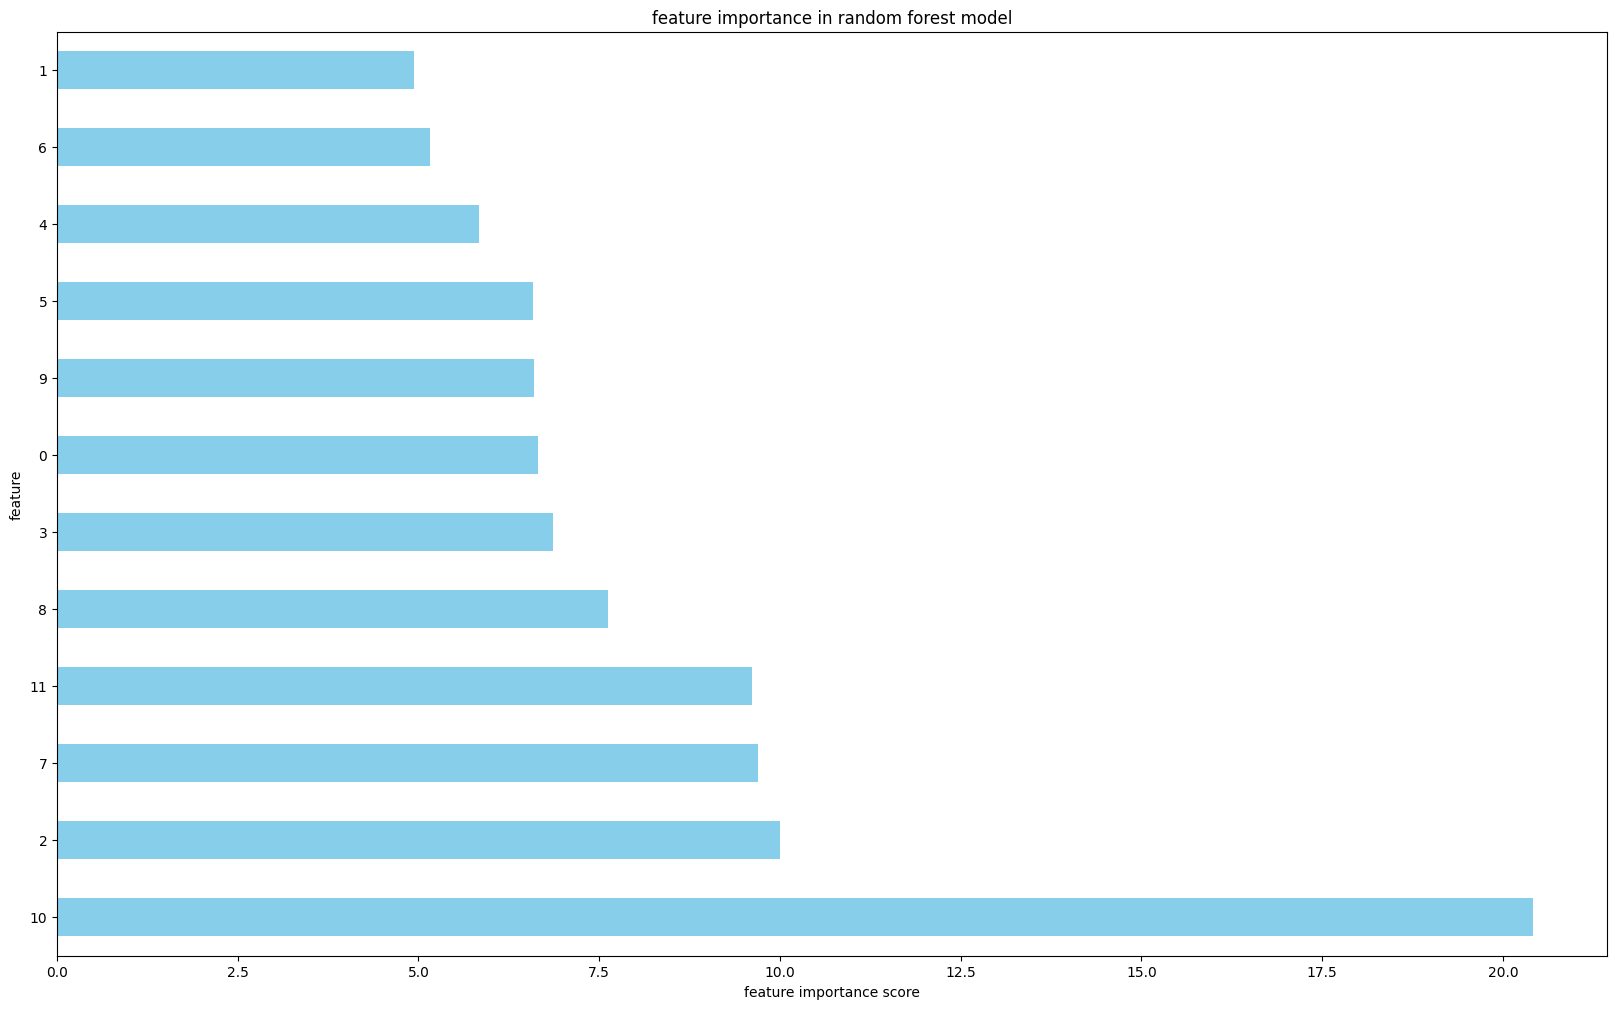

In [33]:
x_train = pd.DataFrame(x_train)
feature_importances = pd.Series(catboost_model.feature_importances_ , index=x_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='barh', color = 'skyblue', figsize=(20, 12))
plt.xlabel('feature importance score')
plt.ylabel('feature')
plt.title('feature importance in random forest model')

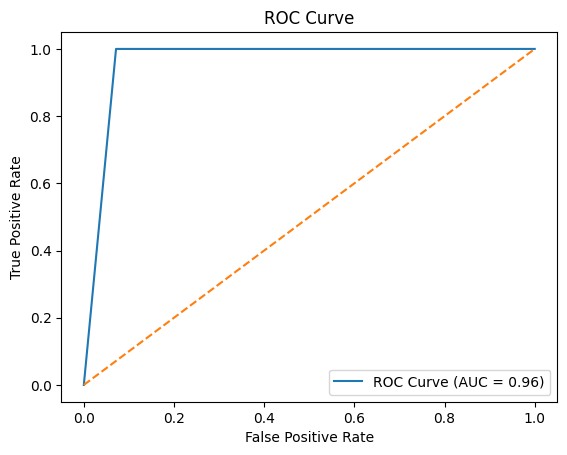

In [34]:
y_probs = catboost_model.predict(x_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

<font size="3">save bestmodel and scaler for prediction new data</font>

In [35]:
with open('catboost_model.txt', 'wb') as file:
    pickle.dump(catboost_model , file)
with open('svc_Model.txt', 'wb') as file:
    pickle.dump(svc_model , file)
with open('scaler.txt', 'wb') as file:
    pickle.dump(scaler , file)